In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import random_clifford, Pauli
from qiskit_aer.primitives import Sampler as AerSampler
from scipy.optimize import curve_fit
import random
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import QasmSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

In [12]:

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='ibm-q-ikerbasque/vicomtech/elkartek-kubit',
#     token='TOKEN'
# )
# backend = service.least_busy()
backend = FakeSherbrooke()
backend

In [ ]:

def decay(x, A, p, B): return A * (p ** x) + B

def pauli_to_basis_gates(qc, pauli_str):
    """ Aplica rotaciones para medir en la base de Pauli dada. """
    for i, p in enumerate(reversed(pauli_str)):
        if p == 'X':
            qc.h(i)
        elif p == 'Y':
            qc.sdg(i)
            qc.h(i)
def random_nontrivial_pauli(n):
    pauli_str = ''
    while True:
        pauli_str = ''.join(np.random.choice(['I', 'X', 'Y', 'Z'], size=n))
        if not all(p == 'I' for p in pauli_str):  # Asegura que no sea la identidad
            break
    return Pauli(pauli_str)
# Parámetros del experimento
step = 2
M = 50
N = 1
m_vals = np.arange(1, M, step)
k = 1024
n = 50  # circuitos por profundidad

results = []
EPC = 0

while EPC < 0.5 and N < 5:
    start = time.time()
    f_means, f_stds = [], []

    for m in m_vals:
        print(f">>> Longitud Clifford: {m} Numero de qubits: {N}")
        fidelidades = []

        for _ in range(n):
            # 1. Generar m Cliffords aleatorios
            cliffords = [random_clifford(N) for _ in range(m)]
            composed = cliffords[0]
            for C in cliffords[1:]:
                composed = composed.compose(C)

            # 2. Preparar circuito
            qc = QuantumCircuit(N)
            for C in cliffords:
                qc.append(C.to_circuit(), range(N))

            # 3. Elegir observable P ≠ I
            while True:
                P = random_nontrivial_pauli(N)
                if not P.to_label().count('I') == N:
                    break

            # 4. Evolucionar P bajo el circuito
            U = composed
            P_prime = P.evolve(U)

            # 5. Rotar a la base de medición de P'
            pauli_to_basis_gates(qc, P_prime.to_label())
            qc.measure_all()

            # 6. Ejecutar
            transpiled = transpile(qc, backend=backend, optimization_level=3, initial_layout=list(range(N)))
            sampler = Sampler(mode = backend)
            result = sampler.run([transpiled], shots=k).result()[0]
            counts = result.data.meas.get_counts()

            # 7. Calcular valor esperado de P'
            expval = 0
            for bitstring, prob in counts.items():
                parity = 1
                bitstring = bitstring.zfill(len(P_prime.to_label()))
                for i, p in enumerate(P_prime.to_label()):
                    if p != 'I':
                        bit = int(bitstring[::-1][i])
                        parity *= 1 if bit == 0 else -1
                expval += parity * (prob/k)

            fidelidades.append((1 + expval) / 2)

        f_means.append(np.mean(fidelidades))
        f_stds.append(np.std(fidelidades))

    # Ajustar exponencial y calcular EPC
    params, cov = curve_fit(decay, m_vals, f_means, p0=[0.5, 0.99, 0.5], bounds=([0, 0, 0], [1, 1, 1]))
    perr = np.sqrt(np.diag(cov))
    A_fit, p_fit, B_fit = params
    d = 2**N
    EPC = (1 - p_fit) * (d - 1) / d
    EPC_err = perr[1] * (d - 1) / d
    results.append((m_vals.copy(), f_means.copy(), f_stds.copy(), params, perr, EPC, EPC_err, A_fit, p_fit))

    N += 1
    if time.time() - start > 1800: break

>>> Longitud Clifford: 1 Numero de qubits: 1
>>> Longitud Clifford: 3 Numero de qubits: 1
>>> Longitud Clifford: 5 Numero de qubits: 1
>>> Longitud Clifford: 7 Numero de qubits: 1
>>> Longitud Clifford: 9 Numero de qubits: 1
>>> Longitud Clifford: 11 Numero de qubits: 1
>>> Longitud Clifford: 13 Numero de qubits: 1


In [ ]:
fig, axs = plt.subplots(1, len(results), figsize=(6 * len(results), 5))

# Graficar resultados 
if len(results) == 1:
    axs = [axs]

for i, (m_vals_i, f_means_i, f_stds_i, params_i, perr_i, EPC_i, EPC_err_i, A_fit, p_fit) in enumerate(results):
    axs[i].errorbar(m_vals_i, f_means_i, yerr=f_stds_i, fmt='o', label='Datos')
    m_fit = np.linspace(min(m_vals_i), max(m_vals_i), 100)
    axs[i].plot(m_fit, decay(m_fit, *params_i), label='Ajuste exponencial')
    axs[i].set_title(f'{i+1} qubits (EPC={EPC_i:.3f})')
    axs[i].set_xlabel('Profundidad m')
    axs[i].set_ylabel('Fidelidad')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()



En ordenador real con M = 401 y step = 100 (m = 1,101,201,301)  

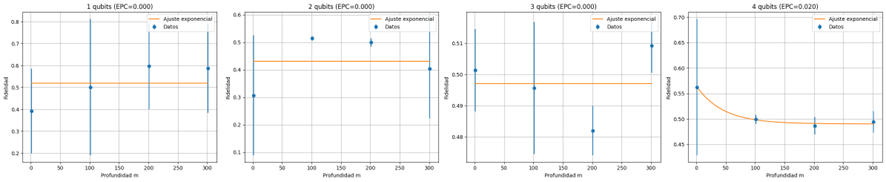
 
En ordenador fake backend con M = 401 step = 100 (m = …)

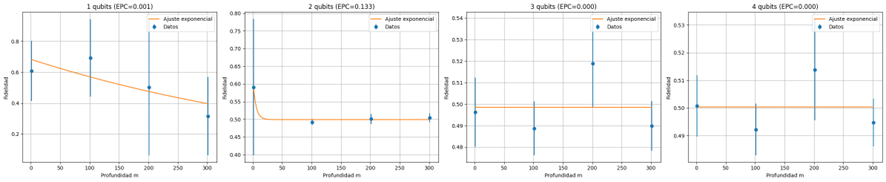
 
